In [1]:
#from graphviz import Digraph
#from torch.autograd import Variable

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

#from utils import ALL_LETTERS, N_LETTERS
#from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

#import os
#os.environ["PATH"] += os.pathsep + 'C:/Users/Erick/miniconda3/envs/pytorch_examples/Library/bin/graphviz/'

In [2]:
#Get data from csv file
pddata_train = pd.read_csv("data/stock_price/google/Google_Stock_Price_Train.csv")
pddata_test = pd.read_csv("data/stock_price/google/Google_Stock_Price_Test.csv") 
# Preview the first 5 lines of the loaded data 
pddata_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
data_train = pddata_train.loc[:, ["Open"]].values

#data_train

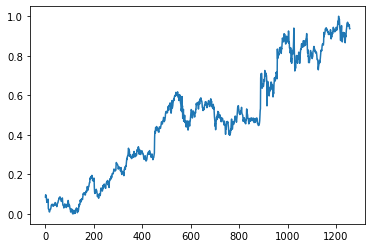

In [4]:
# feature scalling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range= (0,1)) # defining of Scaler
data_train_scaled = scaler.fit_transform(data_train) # applying to Scaler to train

plt.plot(data_train_scaled)
plt.show()

0.08581367661284323

In [228]:
# We add first 50 locution to "X_train" and we 51. locution to "y_train" .
X_train = []
y_train = []
timesteps = 50

#This loop, makes X, Y trainings pairs from data_train_scaled list.
#data_train_scaled has 1258 items, items from 0 to 49, will be X[0] and item 50 will be Y[0]
#items 50 to 99 will be X[1], item 100 will be Y[1], and so on. This way previous 50 items will be
#the input to estimate the next value.
for i in range(timesteps, data_train_scaled.shape[0]):
    X_train.append(data_train_scaled[i-timesteps:i,0])
    y_train.append(data_train_scaled[i,0])

X_train, y_train = np.array(X_train, dtype=np.float32), np.array(y_train, dtype=np.float32)


# Reshaping
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Dimension of array is 3.
y_train = y_train.reshape(y_train.shape[0], 1)  # Dimension of array is 3.

In [208]:
#this cell can be deleted

print(np.shape(X_train))
print(np.shape(y_train))

#data_train_scaled[51 - 50: 51, 0]

#print(np.shape(y_train))
#print(X_train[1])
#print(X_train[2])
y_train[0]

(1208, 50)
(1208,)


0.052143015

In [209]:
class LSTM(torch.nn.Module):

    def __init__(self, input_size, output_size):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = output_size
        self.output_size = output_size
        
        self.forget = torch.nn.Linear(input_size + self.hidden_size, output_size)
        self.keep1 = torch.nn.Linear(input_size + self.hidden_size, output_size)
        self.keep2 = torch.nn.Linear(input_size + self.hidden_size, output_size)
        self.output = torch.nn.Linear(input_size + self.hidden_size, output_size)
        self.outputPred = torch.nn.Linear(output_size, 1)
        
    def forward(self, input_tensor, hidden_tensor, cell_tensor):
        
        combined_input_hidden = torch.cat((input_tensor, hidden_tensor), 1)
        
        ft = torch.sigmoid(self.forget(combined_input_hidden))
        it = torch.sigmoid(self.keep1(combined_input_hidden))
        cell_candidate = torch.tanh(self.keep2(combined_input_hidden))
        
        new_cell = (ft * cell_tensor) + (it * cell_candidate)
        
        ot = torch.sigmoid(self.output(combined_input_hidden))
        
        new_hidden = ot * torch.tanh(new_cell)
        
        output = self.outputPred(new_hidden)
        
        return output, new_hidden, new_cell
    
    def init_hidden(self):
        return torch.zeros(1, self.output_size)

In [226]:
lstm = LSTM(1, 50)


criterion = torch.nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

In [229]:
##This cell can be deleted


hidden = lstm.init_hidden()
cell = lstm.init_hidden()

rand_index = np.random.choice(np.arange(0, X_train.shape[0]), 1)
    
torch_X_train = torch.from_numpy(X_train[rand_index])
torch_y_train = torch.from_numpy(y_train[rand_index])


output, hidden, cell = lstm(torch.reshape(torch_X_train[0][1], [1, 1]), hidden, cell)

#torch_y_train.dtype
loss = criterion(output, torch_y_train)
#torch_y_train.shape

In [230]:
def train(price_input_tensor, price_target_tensor):
    hidden = lstm.init_hidden()
    cell = lstm.init_hidden()
    
    for i in range(price_input_tensor.size()[0]):
        
        output, hidden, cell = lstm(torch.reshape(price_input_tensor[i], [1, 1]), hidden, cell)
        
    loss = criterion(output, price_target_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

4999 50.0 0.0006
9999 100.0 0.0001


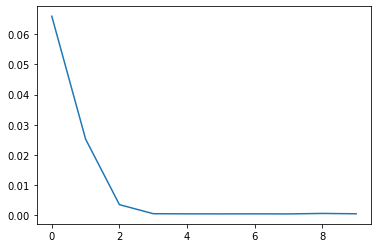

In [231]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 10000

for i in range(n_iters):
    
    rand_index = np.random.choice(np.arange(0, X_train.shape[0]), 1)
    
    torch_X_train = torch.from_numpy(X_train[rand_index])
    torch_y_train = torch.from_numpy(y_train[rand_index])
    
    output, loss = train(torch_X_train[0], torch_y_train)
    current_loss += loss
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        print(f"{i} {i/n_iters*100:.1f} {loss:.4f}")
        
plt.figure()
plt.plot(all_losses)
plt.show()

In [254]:
predictions = []

with torch.no_grad():
    
    for i in range(X_train.shape[0]):
        
        hidden = lstm.init_hidden()
        cell = lstm.init_hidden()
        
        torch_X_train = torch.from_numpy(X_train[i])


        for i in range(torch_X_train.size()[0]):
            output, hidden, cell = lstm(torch.reshape(torch_X_train[i], [1, 1]), hidden, cell)
        
        predictions.append(output[0])

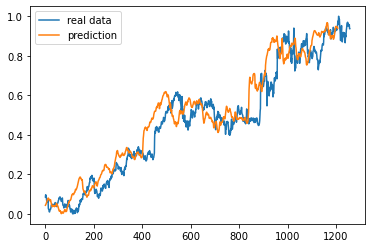

In [259]:
plt.plot(data_train_scaled)
plt.plot(predictions)
plt.legend(["real data", "prediction"])
plt.show()

### ToDo

* Split the original dataset in train and test, and make another example.

### Notes

* https://www.kaggle.com/tmtdmr/rnn-vs-lstm-on-google-stock-price-dataset